# Training and evaluation of modified IM2ELEVATION model

In [1]:
# Ensures runtime code is updated when source code of libraries are updated as well
%load_ext autoreload
%autoreload 2

In [2]:
# Import of necessary libraries

import os
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
import numpy as np
import pickle
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import ssl
import tqdm

from osgeo import gdal
import geopandas as gpd
import shapely

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.preprocessing import Normalizer

# FastAI
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *

import utils.data_utils as du
import utils.sp_utils as sp



In [3]:
# User modules

from utils.models import senet
from utils.models import modules
from utils.models import net

In [4]:
# Check if gpu/cuda is available
import torch
torch.cuda.is_available()

True

In [5]:
# Constants
CHECKPT_PATH = "pretrained_model/im2elevation/Block0_skip_model_110.pth.tar"
UMP = ["AverageHeightArea", 
            "AverageHeightBuilding", 
            "AverageHeightTotalArea", 
            "Displacement", 
            "FrontalAreaIndex",
            "MaximumHeight",
            "PercentileHeight",
            "PlanarAreaIndex",
            "RoughnessLength",
            "StandardDeviation"]


## Build Dataset

In [6]:
Y_tokyo = gpd.read_feather("data/Y_UMP/Y_tokyo_4.feather")
ds_tokyo = du.UMPDataset(Y_tokyo, "data/X_sentinel/tokyo")

In [7]:
Y_osaka = gpd.read_feather("data/Y_UMP/Y_osaka_4.feather")
ds_osaka = du.UMPDataset(Y_osaka, "data/X_sentinel/osaka")

In [8]:
ds_osaka[0][0].dtype, ds_osaka[0][1].dtype

(dtype('float32'), dtype('float32'))

### Visualisation Functions

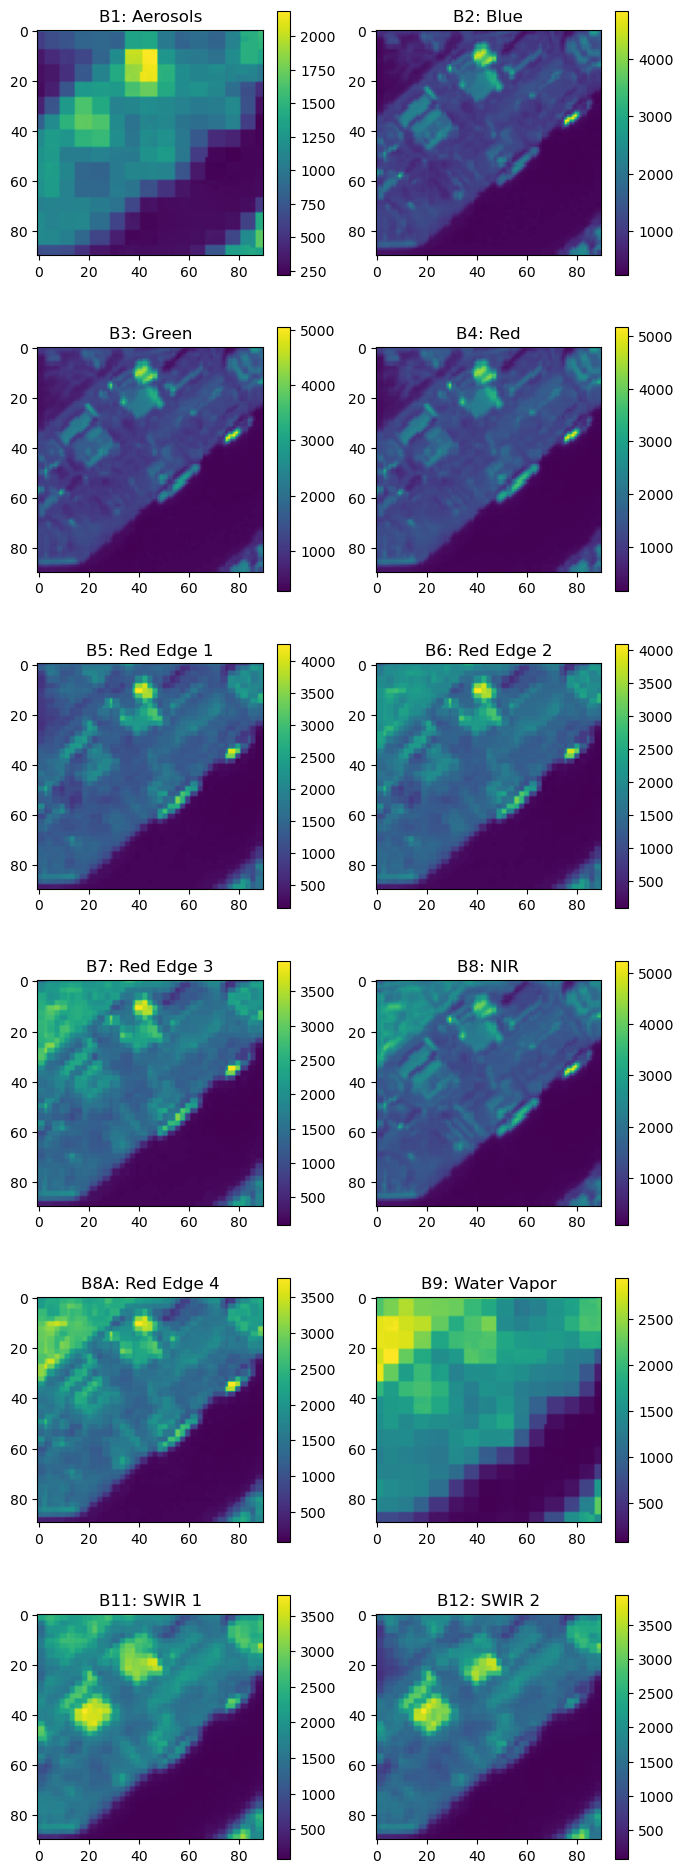

In [10]:
du.plotArray(ds_osaka[0][0])

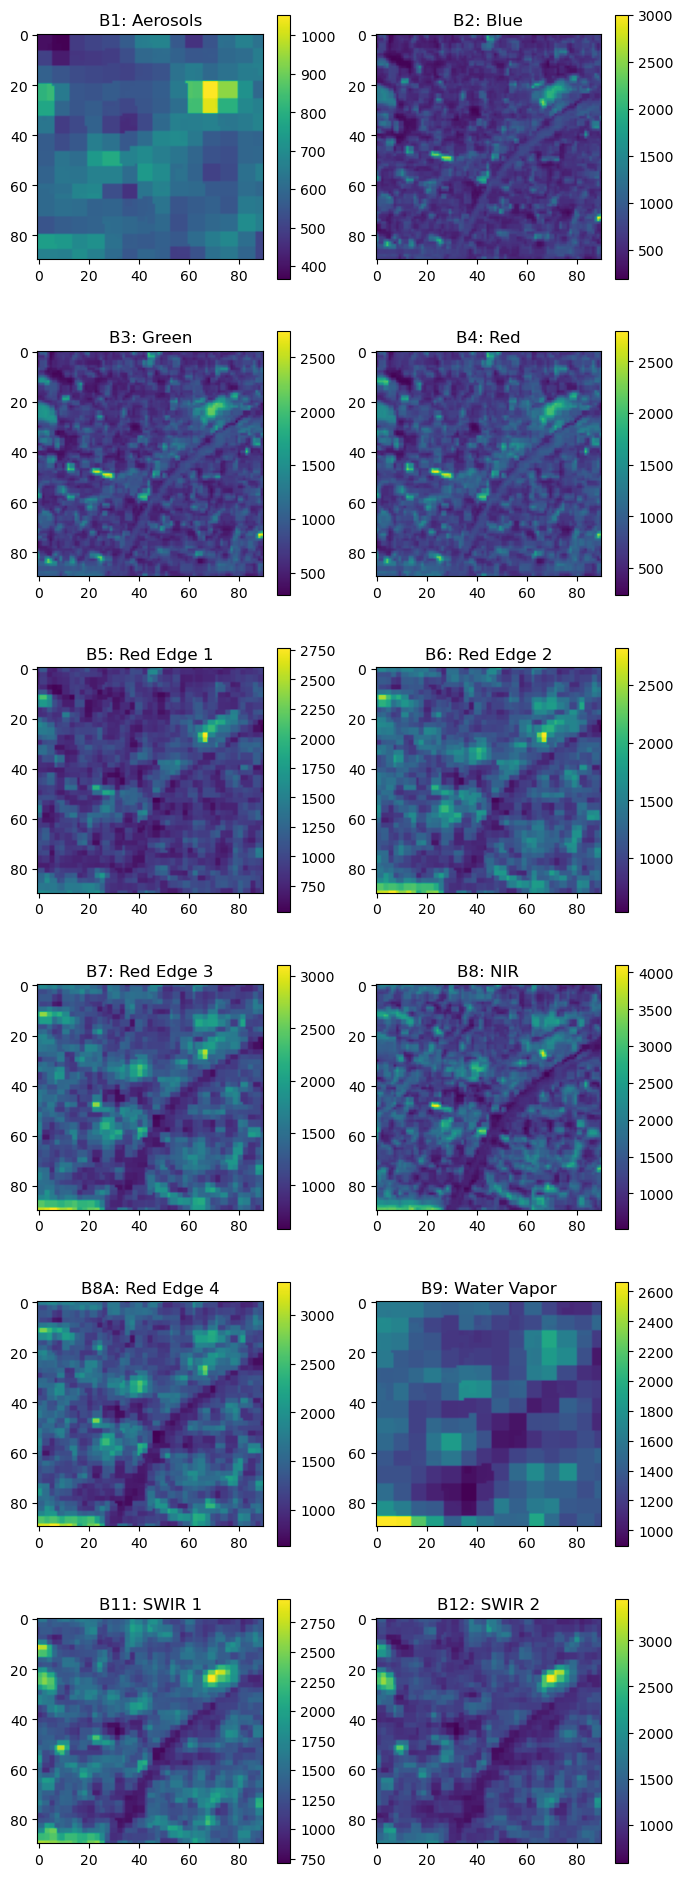

In [11]:
du.plotArray(ds_tokyo[0][0])

### Check dataset

In [80]:
len(ds_osaka), len(ds_tokyo)

(1145, 3286)

In [81]:
# Check for shape discrepancies
for i in range(len(ds_osaka)):
    ds_osaka[i]

In [82]:
# Check for shape discrepancies
for i in range(len(ds_tokyo)):
    ds_tokyo[i]

In [87]:
ds_tokyo.channel_max

[5232.0,
 12216.0,
 14792.0,
 16032.0,
 15665.0,
 15742.0,
 15663.0,
 15607.0,
 15569.0,
 7385.0,
 14959.0,
 15063.0]

### Create FastAI dataloaders

In [9]:
dl = DataLoaders().from_dsets(ds_tokyo, ds_osaka, bs= 8, device=torch.device('cuda'))

#### Validate the shape and len

In [24]:
# Check that dimensions are right
test_batch = dl.one_batch()

In [26]:
# Validate shape
test_batch[0].shape, test_batch[1].shape

(torch.Size([8, 12, 90, 90]), torch.Size([8, 10]))

In [27]:
# Validate len
len(dl.train_ds), len(dl.valid_ds)

(3286, 1145)

## Training the Model

### Extract the max for normalisation

In [27]:
dl.train_ds.channel_max

[5232.0,
 12216.0,
 14792.0,
 16032.0,
 15665.0,
 15742.0,
 15663.0,
 15607.0,
 15569.0,
 7385.0,
 14959.0,
 15063.0]

In [28]:
dl.train_ds.UMP_max

[179.837,
 69.9,
 19.801067,
 0.01881086,
 1.0278143,
 262.0,
 217.22,
 0.4841617,
 34.540844,
 45.97128]

### Model using custom weights (12 channels)
- Using weights from IM2ELEVATION
- Expand model to accept 12 channels instead of just 3

In [10]:
# Load weights from IM2ELEVATION and delete unnecessary layers
checkpoint = torch.load(CHECKPT_PATH)
# checkpoint = torch.load("trained_models/model_customhead_w_64_40.pth")

to_delete = []
# for layer in checkpoint.keys():
for layer in checkpoint["state_dict"].keys():
    if any([word in layer.upper() for word in ["HARM", "R.CONV4", "R.BN4", "R2"]]):
    # if any([word in layer.upper() for word in ["HARM", "R.CONV3", "R.BN3", "R.CONV4", "R.BN4"]]):
        to_delete.append(layer)
print(to_delete)

for i in to_delete:
    # checkpoint.pop(i)
    checkpoint["state_dict"].pop(i)

# Load Weights
ssl._create_default_https_context = ssl._create_unverified_context

original_model = senet.senet154()

Encoder = modules.E_senet(original_model, dl.train_ds.channel_max)
# model = net.model(Encoder, num_features=2048, block_channel = [256, 512, 1024, 2048])

model = net.model_n12(Encoder, num_features=2048, block_channel = [256, 512, 1024, 2048])




['E.Harm.dct', 'E.Harm.weight', 'E.Harm.bias', 'R.conv4.weight', 'R.conv4.bias']


In [11]:
# Duplicate the weights for the encoders
for k in list(checkpoint["state_dict"].keys()):
    if "E." in k:
        for i in range(4):
            checkpoint["state_dict"][f"E{i}." + k[2:]] = checkpoint["state_dict"][k]




In [12]:
for k in list(checkpoint.keys()):
    if "E." in k:
        for i in range(4):
            checkpoint[f"E{i}." + k[2:]] = checkpoint[k]

In [11]:
# Look at keys/weights of interests
koi = []
for k in list(checkpoint.keys()):
    if "E1." in k:
        koi.append(k)
koi


[]

In [12]:
# Load trimmed im2elevation weights
model.load_state_dict(checkpoint["state_dict"], strict=False)

# Clear memory
del checkpoint
gc.collect()
torch.cuda.empty_cache()

In [13]:
# Load trimmed im2elevation weights
model.load_state_dict(checkpoint, strict=False)

# Clear memory
del checkpoint
gc.collect()
torch.cuda.empty_cache()

#### Merging the channels

To merge the channels, the inputs are put to run in parallel until around the mid-way point of the senet backbone, before merging them...?

In [13]:
model = net.model_n12(Encoder, num_features=2048, block_channel = [256, 512, 1024, 2048])
# merged_model = convert_network(model, torch.float16)

### Check Model Sanity

In [18]:
test_batch = dl.one_batch()[0]
test_batch.dtype

torch.float32

In [19]:
model.eval()
model.cuda()
model(test_batch).shape

torch.Size([8, 10])

### Loss and Metrics

In [13]:
# Loss Function

def mse_weighted(pred, actual, UMP_max= dl.train_ds.UMP_max):
    """
    Weighted loss function that normalises the predictions based on the parameters used to normalise the actual during training
    """
    loss = tensor(0).float()
    loss.requires_grad_(True)
    for ump in range(pred.shape[1]):
        # loss = torch.add(loss, F.mse_loss(pred[:, ump], actual[:, ump]))
        loss = torch.add(loss, torch.div(F.mse_loss(pred[:, ump], actual[:, ump]), UMP_max[ump]**2))
    if loss.isnan().sum() > 1:
        raise ValueError([pred, actual])
    return loss.float()


In [14]:
# List of metrics
"""
"AverageHeightArea", 
"AverageHeightBuilding", 
"AverageHeightTotalArea", 
"Displacement", 
"FrontalAreaIndex",
"MaximumHeight",
"PercentileHeight",
"PlanarAreaIndex",
"RoughnessLength",
"StandardDeviation"
"""
def AverageHeightArea_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 0], actual[:, 0]))

def AverageHeightBuilding_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 1], actual[:, 1]))

def AverageHeightTotalArea_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 2], actual[:, 2]))

# def Displacement_RMSE(pred, actual):
#     return math.sqrt(F.mse_loss(pred[:, 3], actual[:, 3]))

def FrontalAreaIndex_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 3], actual[:, 3]))
    # return math.sqrt(F.mse_loss(pred[:, 4], actual[:, 4]))

def MaximumHeight_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 4], actual[:, 4]))
    # return math.sqrt(F.mse_loss(pred[:, 5], actual[:, 5]))

def PercentileHeight_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 5], actual[:, 5]))
    # return math.sqrt(F.mse_loss(pred[:, 6], actual[:, 6]))

def PlanarAreaIndex_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 6], actual[:, 6]))
    # return math.sqrt(F.mse_loss(pred[:, 7], actual[:, 7]))

# def RoughnessLength_RMSE(pred, actual):
#     return math.sqrt(F.mse_loss(pred[:, 8], actual[:, 8]))

def StandardDeviation_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 7], actual[:, 7]))
    # return math.sqrt(F.mse_loss(pred[:, 9], actual[:, 9]))

metrics = [
    AverageHeightArea_RMSE, 
    AverageHeightBuilding_RMSE,
    AverageHeightTotalArea_RMSE,
    # Displacement_RMSE,
    FrontalAreaIndex_RMSE,
    MaximumHeight_RMSE,
    PercentileHeight_RMSE,
    PlanarAreaIndex_RMSE,
    # RoughnessLength_RMSE,
    StandardDeviation_RMSE
]

### Train Model

In [15]:
# Need better loss due to scale difference
model.train()
learn = Learner(dl, model, loss_func= mse_weighted, metrics= metrics, cbs=[MixedPrecision, FP16TestCallback])

In [ ]:
learn.lr_find()

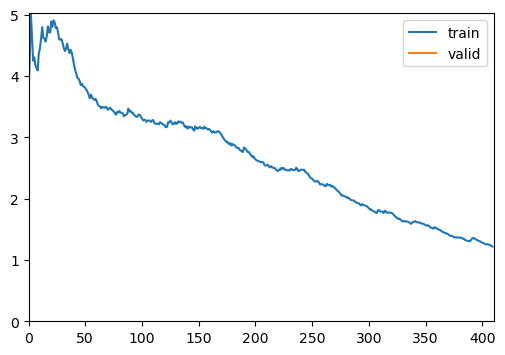

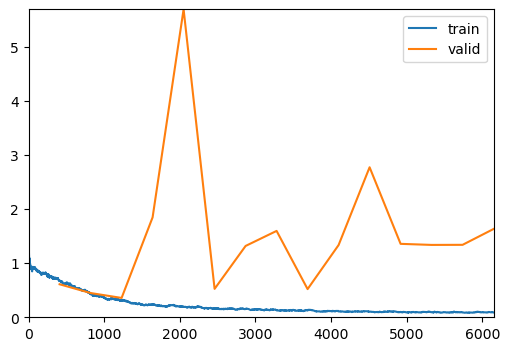

In [16]:
learn.fine_tune(15, 0.001, freeze_epochs= 1, cbs= [ShowGraphCallback()])

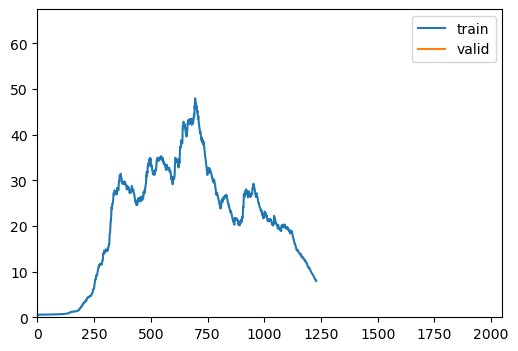

KeyboardInterrupt: 

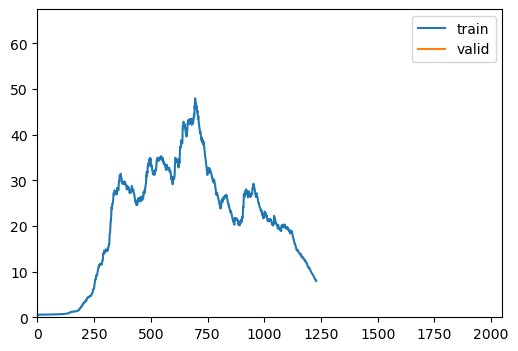

In [19]:
learn.fit_one_cycle(5, 0.001, cbs= [ShowGraphCallback()])

In [17]:
# Plateaus around 30
name = "v4_ump_cut_12ch_8_15" # <description>_<batch_size>_<epochs>
torch.save(model.state_dict(), f"trained_models/model_weight_{name}.pth")
torch.save(model, f"trained_models/model_{name}.pth")

with open(f"trained_models/model_records_{name}.pkl", "wb") as f:
    pickle.dump(learn.recorder.values, f)

## Visualising Model Performance (New ver.)

### Load Data

In [13]:
# Dataloader for evaluation only (large batch size)
# dl_eval = DataLoaders().from_dsets(ds_tokyo, ds_osaka, bs= 106, device=torch.device('cuda'))
# for i in dl_eval[0]:
#     test_batch = i
#     break
# with open("test_batch.pkl", "wb") as f:     
#     pickle.dump(test_batch, f)

In [10]:
# New train data batch
with open("test_batch.pkl", "rb") as f:     
    test_batch = pickle.load(f)

In [11]:
# Old train/val
# Import train and validation
with open("data/x_train_tokyo.pkl", "rb") as f:
    x_train = pickle.load(f)

with open("data/x_val_tokyo.pkl", "rb") as f:
    x_val = pickle.load(f)

with open("data/y_train_tokyo.pkl", "rb") as f:
    y_train = pickle.load(f)

with open("data/y_val_tokyo.pkl", "rb") as f:
    y_val = pickle.load(f)

In [12]:
# Util classes
class NDNormalizer:
    """
    Class that normalises the values from 0 - 255 to match the inputs that the original senet is trained on
    """
    def __init__(self, x):
        self.min_x = x.min()
        self.max_x = x.max()
    
    def transform(self, new_x):
        return (new_x / self.max_x) * 255

    def revert(self, new_x):
        return new_x * self.max_x / 255

In [13]:
x_norms = []
x_train_norm = np.array(x_train)
for channel in range(x_train.shape[1]):
    x_norms.append(NDNormalizer(x_train[:, channel]))
    # x_norms.append(MinMaxScaler().fit(x_train[:, channel]))
    x_train_norm[:, channel] = x_norms[channel].transform(x_train[:, channel])

y_norms = []
y_train_norm = np.array(y_train)
for ump in range(y_train.shape[1]):
    y_norms.append(NDNormalizer(y_train[:, ump]))
    y_train_norm[:, ump] = y_norms[ump].transform(y_train[:, ump])

### Initialise model with weights

In [14]:
# Load weights from previously trained model
# checkpoint = torch.load("trained_models/model_weight_new_1_12ch_8_15.pth", map_location="cuda:0")
# checkpoint = torch.load("trained_models/model_weight_v2_12ch_8_6.pth", map_location="cuda:0")
# checkpoint = torch.load("trained_models/model_weight_old_12ch_8_15.pth", map_location="cuda:0")
# checkpoint = torch.load("trained_models/model_customhead_w_64_40.pth", map_location="cuda:0")
# checkpoint = torch.load("trained_models/model_weight_v4_ump_cut_12ch_8_15.pth", map_location="cuda:0")
checkpoint = torch.load("trained_models/model_weight_12ch_8_15.pth", map_location="cuda:0")

# to_delete = []
# # for layer in checkpoint.keys():
# for layer in checkpoint.keys():
#     if any([word in layer.upper() for word in ["R2"]]):
#     # if any([word in layer.upper() for word in ["HARM", "R.CONV3", "R.BN3", "R.CONV4", "R.BN4"]]):
#         to_delete.append(layer)
# print(to_delete)

# for i in to_delete:
#     # checkpoint.pop(i)
#     checkpoint.pop(i)


# Rebuild the model
ssl._create_default_https_context = ssl._create_unverified_context
original_model = senet.senet154()
# For the old dataset
Encoder = modules.E_senet(original_model, [x_norms[i].max_x for i in range(0, 12)])
# Encoder = modules.E_senet(original_model, dl.train_ds.channel_max)
# model = net.model_n12(Encoder, num_features=2048, block_channel = [256, 512, 1024, 2048])
model = net.model_n12_visualise(Encoder, num_features=2048, block_channel = [256, 512, 1024, 2048])


# Load in the weights
device = torch.device("cuda")
model.load_state_dict(checkpoint, strict=True)
model.to(device)
model.eval();

In [15]:
# Clear memory
del checkpoint
gc.collect()
torch.cuda.empty_cache()

### Initialise model directly (old models)

In [15]:
# Load CNN Model Directly
# model = torch.load("trained_models/model_customhead.pth")
# model = torch.load("trained_models/model_customhead_64_40.pth")
model = torch.load("trained_models/model_12ch_8_15.pth")
model.eval()
model.cuda()

model.E0.channel_max = [x_norms[i].max_x for i in range(0, 12)]
model.E1.channel_max = [x_norms[i].max_x for i in range(0, 12)]
model.E2.channel_max = [x_norms[i].max_x for i in range(0, 12)]
model.E3.channel_max = [x_norms[i].max_x for i in range(0, 12)]

In [ ]:
# CNN Predictions for x_train
with torch.no_grad():
    preds_trains = tensor([])
    for i in range(0, len(x_train), 64):
        # x_train_cur = tensor(x_train[i, 1:4]).detach().clone().unsqueeze(0)
        x_train_cur = tensor(x_train[i:min(i+64, len(x_train))])
        preds_train = tensor(model(x_train_cur.cuda())).cpu()
        preds_trains = torch.cat([preds_trains, preds_train], 0)
    # preds_val = preds_val.cat([preds_val, tensor(model(tensor(x_val[len(x_val)//2:, 1:4])))], dim= 0)
    print(preds_trains.shape)

torch.Size([2628, 8])


In [ ]:
# CNN Predictions for x_val
with torch.no_grad():
    preds_vals = tensor([])
    for i in range(0, len(x_val), 64):
        x_val_cur = tensor(x_val[i:min(i+64, len(x_val))])
        # x_val_cur = tensor(x_val[i, 1:4]).detach().clone().unsqueeze(0)
        preds_val = tensor(model(x_val_cur.cuda())).cpu()
        preds_vals = torch.cat([preds_vals, preds_val], 0)
    # preds_val = preds_val.cat([preds_val, tensor(model(tensor(x_val[len(x_val)//2:, 1:4])))], dim= 0)
    print(preds_vals.shape)

torch.Size([614, 8])


#### Get predictions (new)

In [12]:
factors = []
factors_1 = []
for i in range(1, len(dl.train_ds) // 2):
    if len(dl.train_ds) % i == 0:
        factors.append(i)
    elif len(dl.train_ds) % i == 1:
        factors_1.append(i)

print("Perfect Batch Sizes:", factors)
print("Missing 1 Batch Sizes", factors_1)

Perfect Batch Sizes: [1, 2, 31, 53, 62, 106]
Missing 1 Batch Sizes [3, 5, 9, 15, 45, 73, 219, 365, 657, 1095]


In [16]:
model.eval()
device = torch.device("cuda")
with torch.no_grad():
    preds = model(test_batch[0].to(device))
    image = test_batch[0]
    cell = test_batch[2]
        
    
# preds = torch.cat(preds)
coords = [float(cell[0][0].cpu()), float(cell[1][0].cpu()), float(cell[2][0].cpu()), float(cell[3][0].cpu())]
cell_poly = shapely.Polygon([(coords[0], coords[1]), (coords[2], coords[1]), (coords[2], coords[3]), (coords[0], coords[3])])
preds.shape

torch.Size([106, 72, 45, 45])

In [14]:
Y_train = np.array([dl_eval.train_ds[i][1] for i in range(len(dl_eval.train_ds))])
Y_train.shape

(3286, 8)

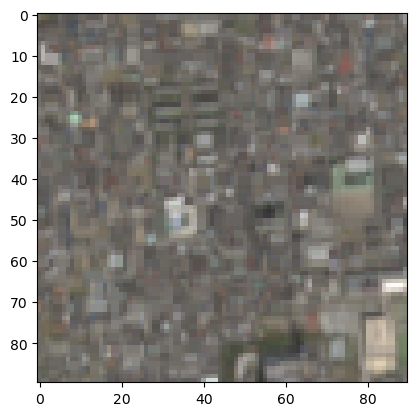

In [17]:
b1 = image[0][3].cpu() # R
b2 = image[0][2].cpu() # G
b3 = image[0][1].cpu() # B
# b1 = dl_eval.train_ds[0][0][3] # R
# b2 = dl_eval.train_ds[0][0][2] # G
# b3 = dl_eval.train_ds[0][0][1] # B
img = np.dstack((b1, b2, b3))
img *= (255.0/img.max())
f = plt.figure()
img = np.array(img, dtype= "uint8")
img = sp.adjust_gamma(img, 2)
plt.imshow(img, interpolation= "nearest")
plt.show()

In [18]:
tokyo_gdf = gpd.read_feather("data/full_Tokyo_plateau/tokyo_fixed.feather")
tokyo_cell_1 = gpd.clip(tokyo_gdf, cell_poly)
df2 = gpd.GeoDataFrame().from_dict({'geometry': [cell_poly], 'height': [0]})
df = pd.concat([df2, tokyo_cell_1])

<AxesSubplot:>

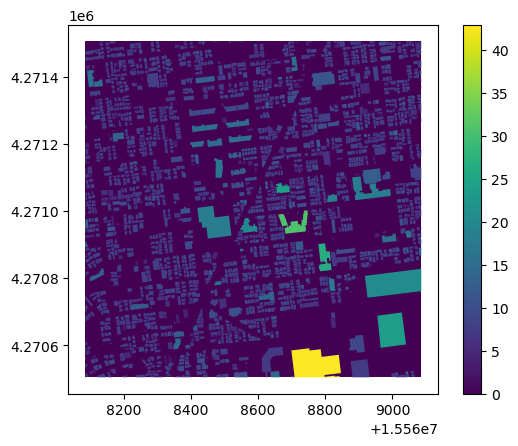

In [19]:
df.plot(column= "height", legend= True)

In [24]:
image.cpu().shape

torch.Size([106, 12, 90, 90])

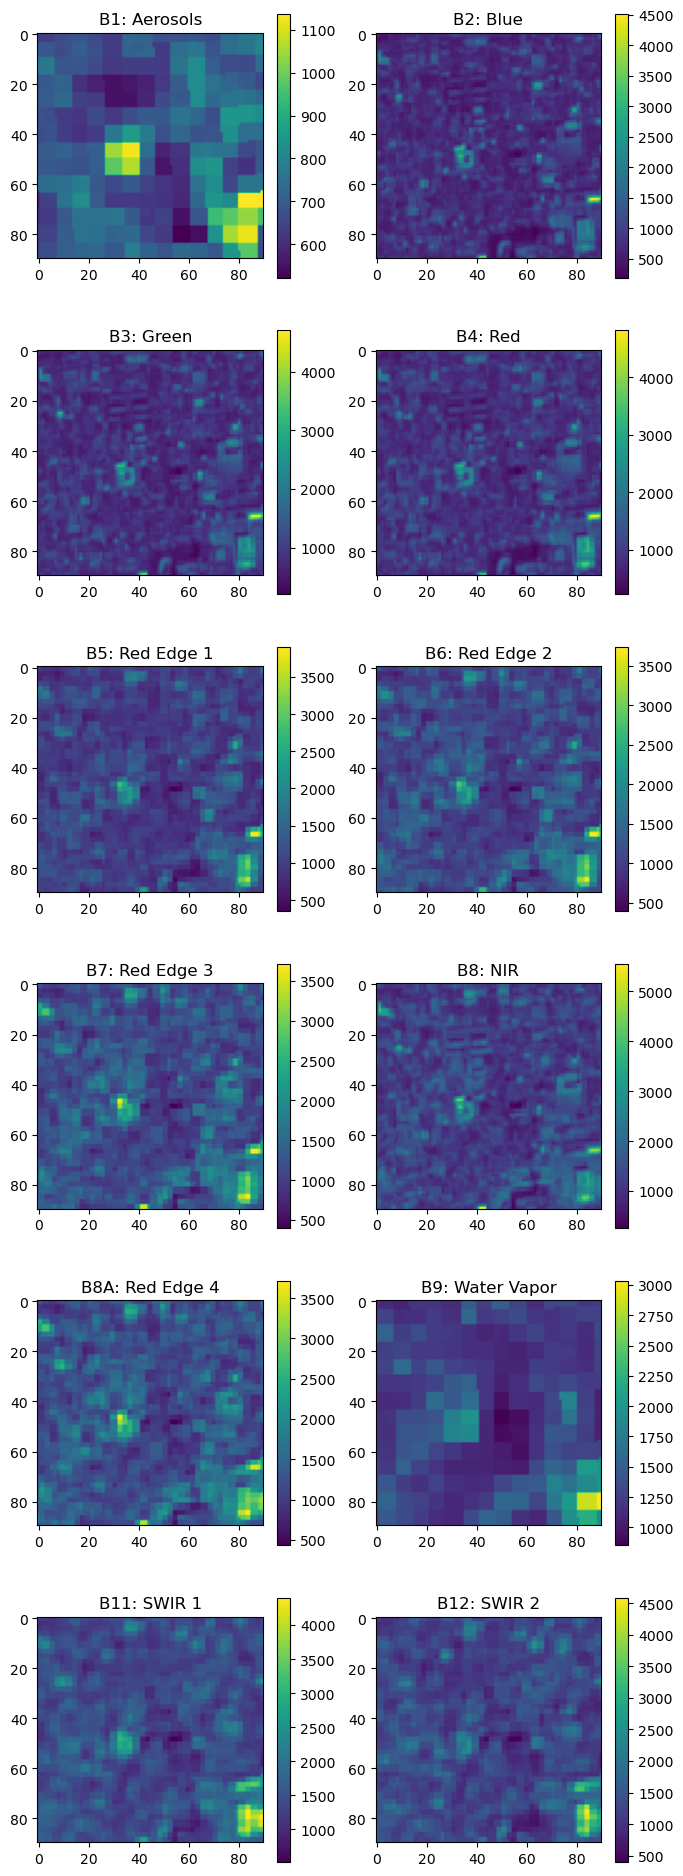

In [20]:
du.plotArray(image.cpu()[0])

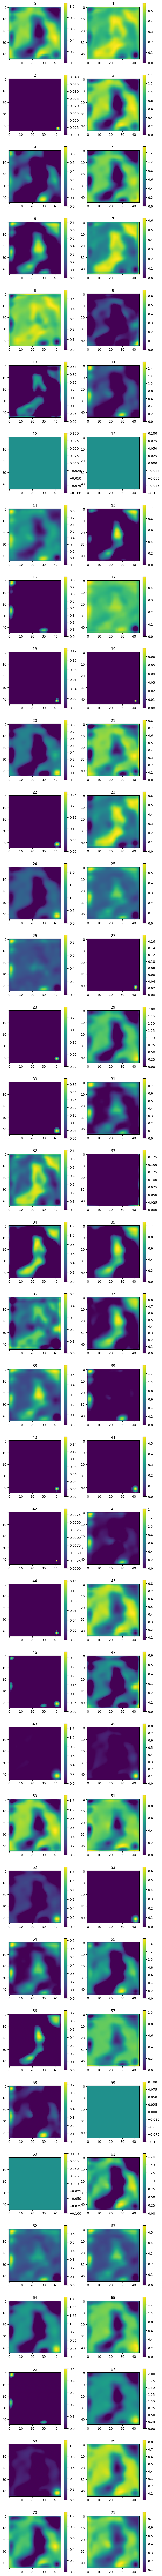

In [21]:
du.plotArray(preds[0].cpu(), len(preds[0]), list(map(str, range(len(preds[0])))))

#### Get predictions (old)

In [19]:
model.eval()
device = torch.device("cuda")
with torch.no_grad():
    preds = []
    for batch_idx in tqdm.tqdm(range(0, len(x_train), 106)):
        batch = torch.tensor(x_train[batch_idx:batch_idx + 106])
        preds.append(model(batch.to(device)))

preds = torch.cat(preds)
preds.shape

100%|██████████| 25/25 [00:20<00:00,  1.19it/s]


torch.Size([2628, 8])

In [20]:
Y_train.shape

(2628, 8)

### Plotting results

In [17]:
x_train.shape

(2628, 12, 91, 91)

In [16]:
Y_train.shape

(2628, 8)

### New Results

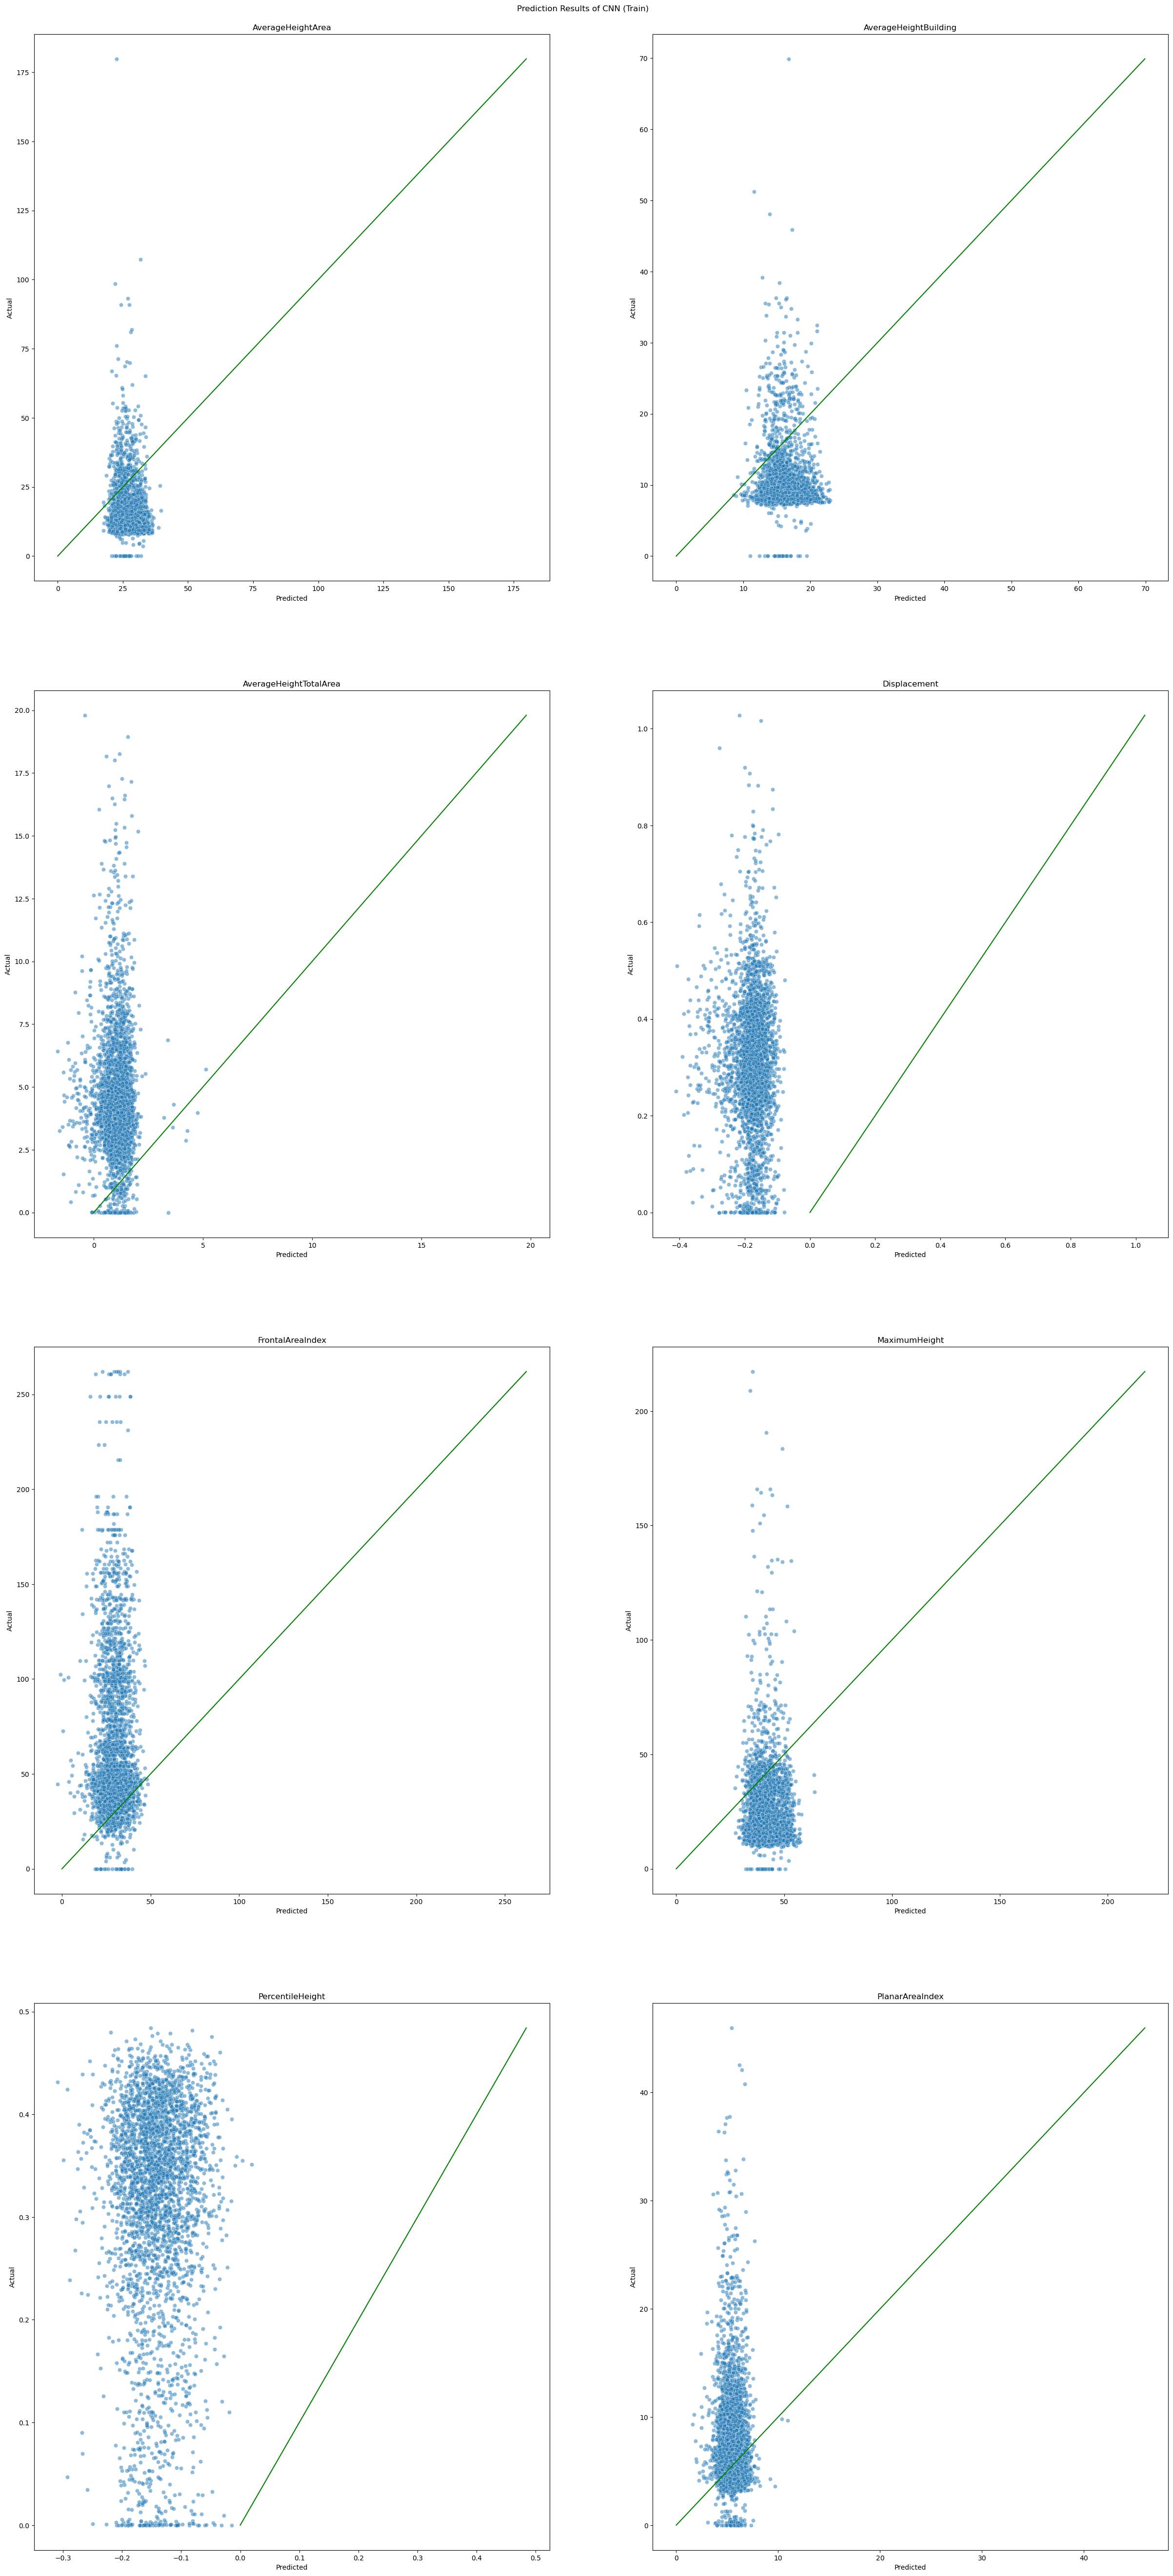

In [16]:
fig, axes = plt.subplots(4, 2, figsize= (30, 60))
fig.suptitle('Prediction Results of CNN (Train)')
fig.subplots_adjust(top=0.97)
for ump in range(8):
    # CNN
    sns.scatterplot(x= preds[:, ump].cpu(), y= Y_train[:, ump], alpha= 0.5, ax= axes[ump//2, ump%2])
    # Baseline
    ax = sns.lineplot(x= Y_train[:, ump], y = Y_train[:, ump], ax= axes[ump//2, ump%2], color= "g")

    # Labels
    ax.set(ylabel= "Actual", xlabel= "Predicted")

    axes[ump//2, ump%2].set_title(f"{UMP[ump]}")

### Old Results

In [23]:
UMP_OLD = ['height_avg_bld', 'height_avg_area', 'height_avg_total', 'height_std',
       'height_max', 'height_percentile', 'planar_index', 'frontal_index']

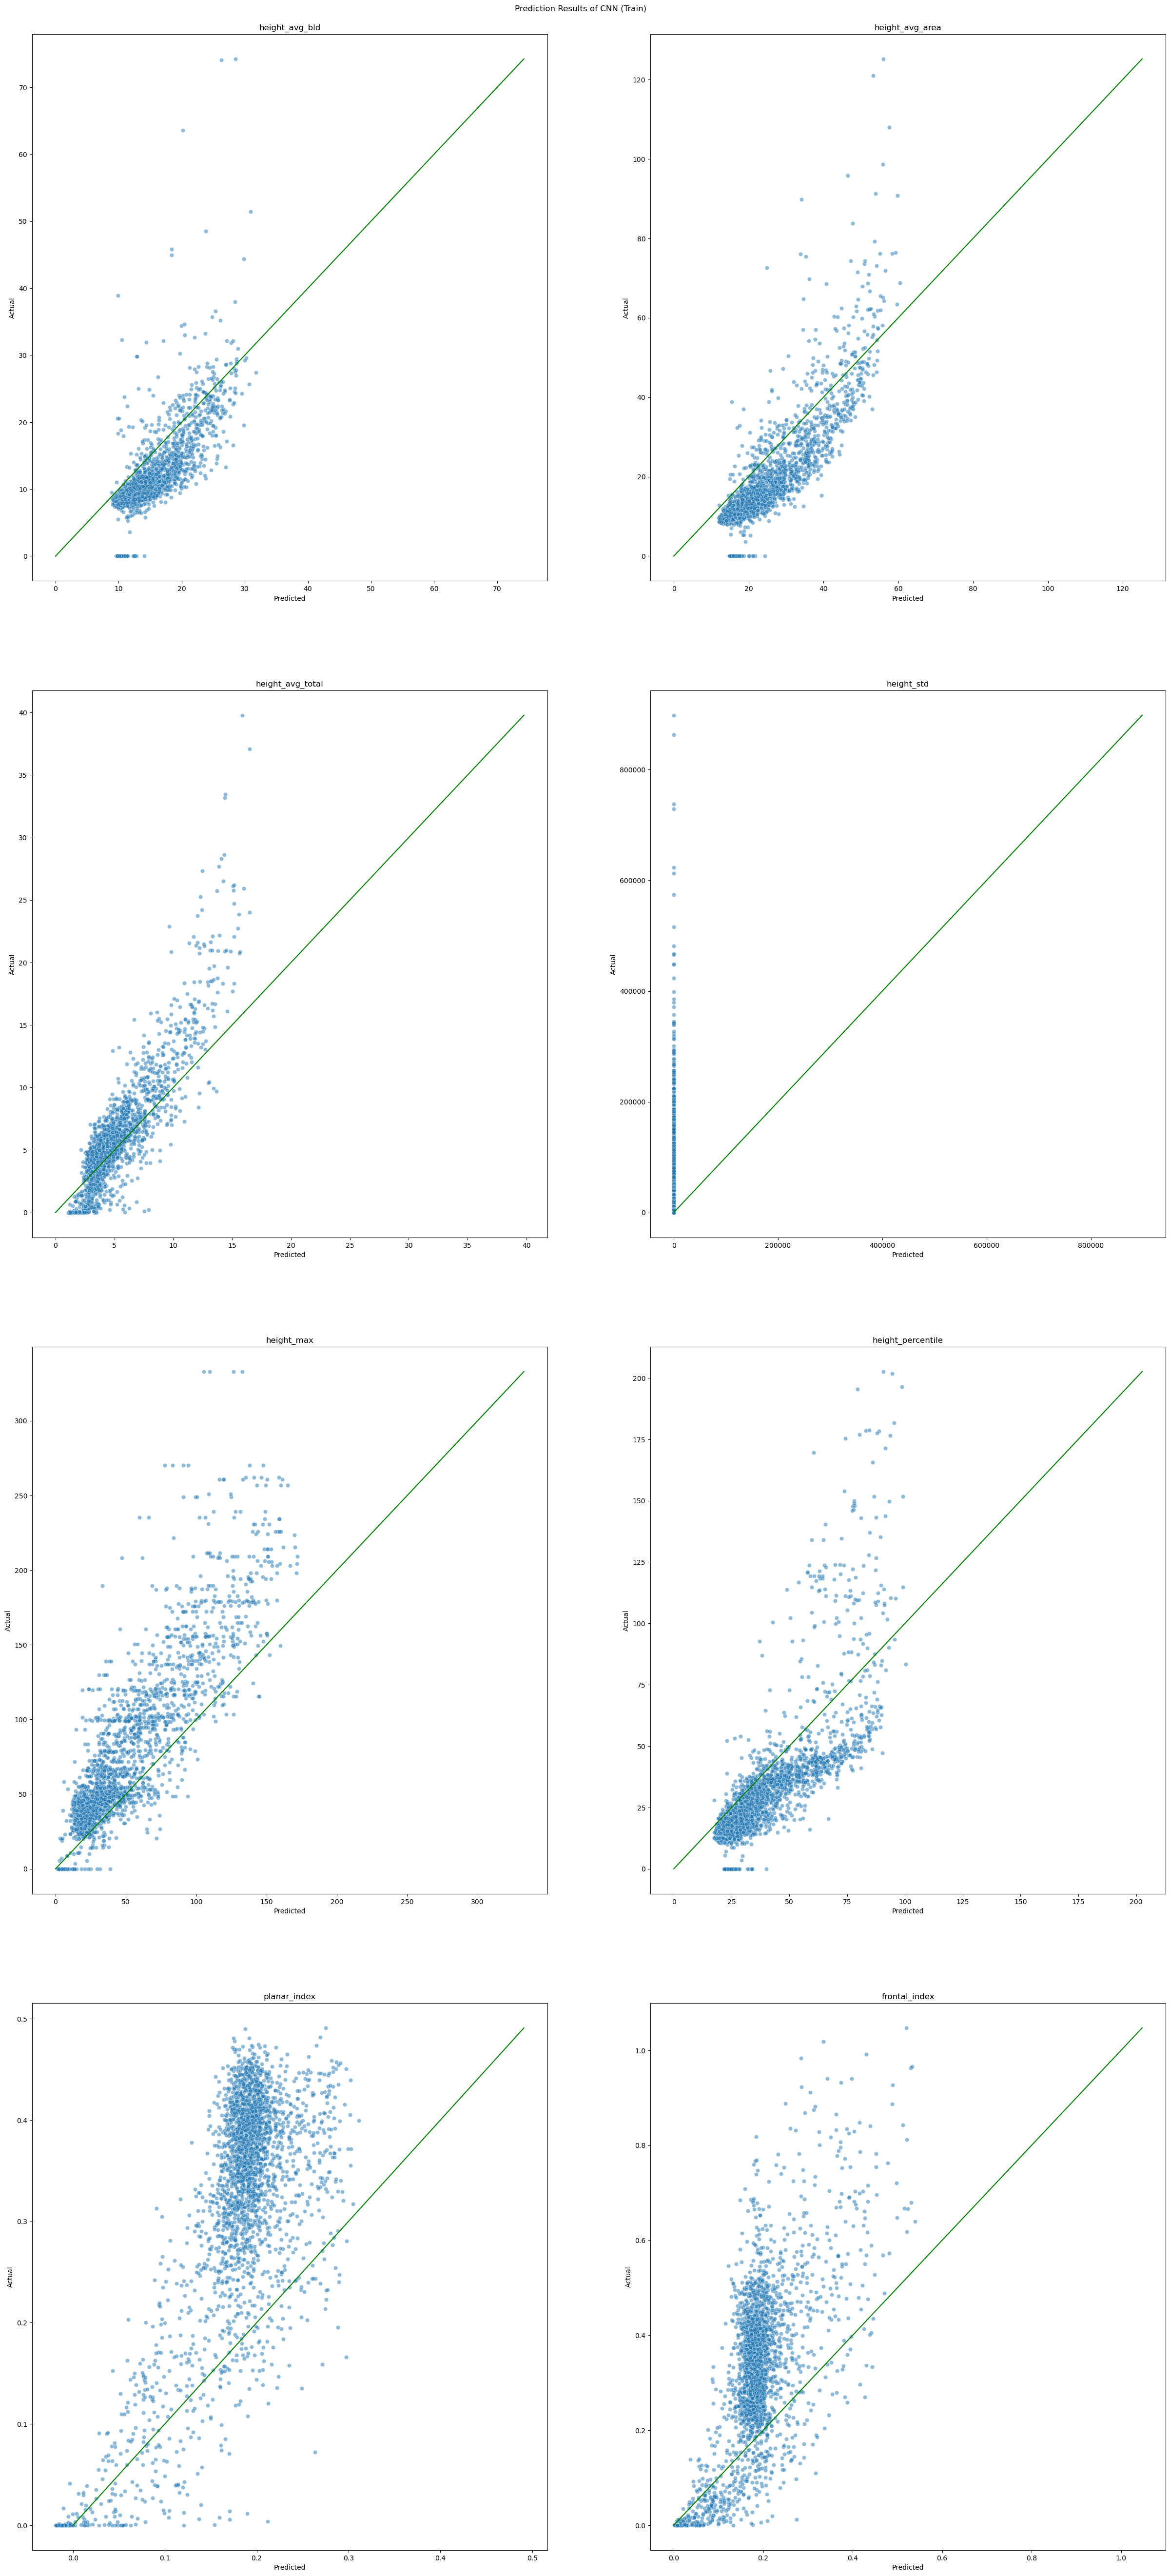

In [25]:
fig, axes = plt.subplots(4, 2, figsize= (30, 60))
fig.suptitle('Prediction Results of CNN (Train)')
fig.subplots_adjust(top=0.97)
for ump in range(8):
    # CNN
    sns.scatterplot(x= preds[:, ump].cpu(), y= Y_train[:, ump], alpha= 0.5, ax= axes[ump//2, ump%2])
    # Baseline
    ax = sns.lineplot(x= Y_train[:, ump], y = Y_train[:, ump], ax= axes[ump//2, ump%2], color= "g")

    # Labels
    ax.set(ylabel= "Actual", xlabel= "Predicted")

    axes[ump//2, ump%2].set_title(f"{UMP_OLD[ump]}")